In [1]:
import torch
from torch import nn
from torchvision.transforms import Lambda
import matplotlib.pyplot as plt
import numpy as np
from frozendict import frozendict
from msdm.domains import GridWorld
from msdm.algorithms import ValueIteration
# from msdm.core.problemclasses.mdp import TabularPolicy
from softmax_policy import TabularPolicy
from msdm.core.distributions import DictDistribution
from dataset import FeaturesDataset
from algorithms import ImitationLearning

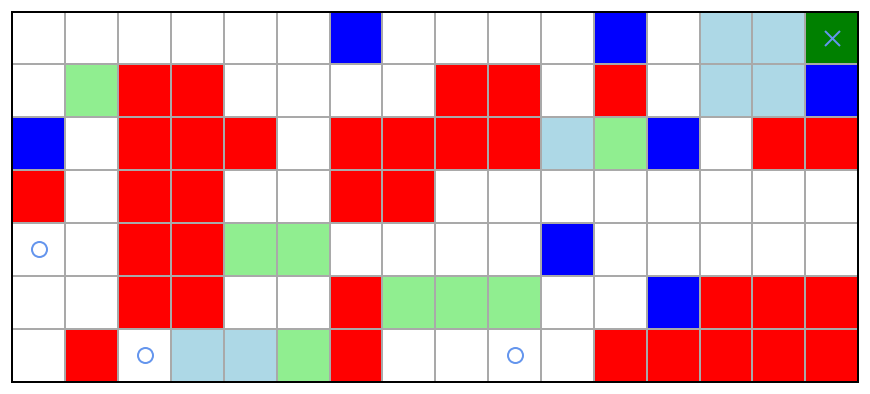

In [2]:
# Create a gridworld
gw = GridWorld(
    tile_array=[
        "......c....c.bbg",
        ".axx....xx.x.bbc",
        "c.xxx.xxxxbac.xx",
        "x.xx..xx........",
        "s.xxaa....c.....",
        "..xx..xaaa..cxxx",
        ".xsbbax..s.xxxxx",
    ],
    feature_rewards={
        'g': 10,
        'x': -500,
        'c': -5,
        '.': 0,
        'a': 0,
        'b': 0,
    },
    absorbing_features=('g'),
    initial_features=('s'),
    discount_rate=0.99,
)
featurecolors = {
    'g': 'green',
    'x': 'red',
    'c': 'blue',
    '.': 'white',
    'a': 'lightgreen',
    'b': 'lightblue'
}
gw.plot(featurecolors=featurecolors)


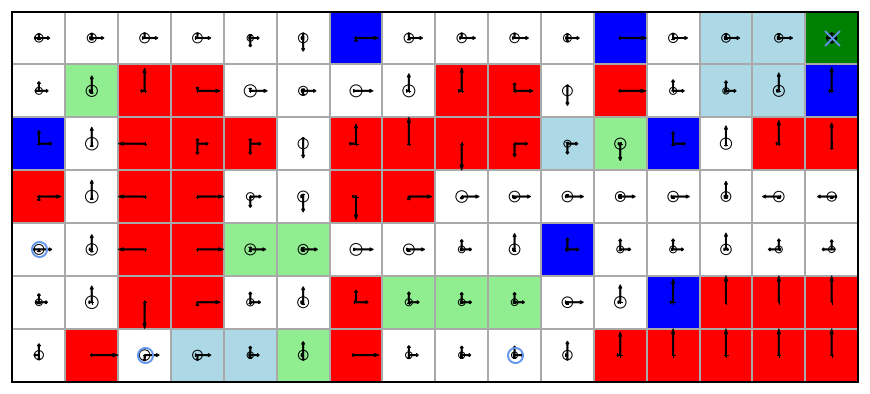

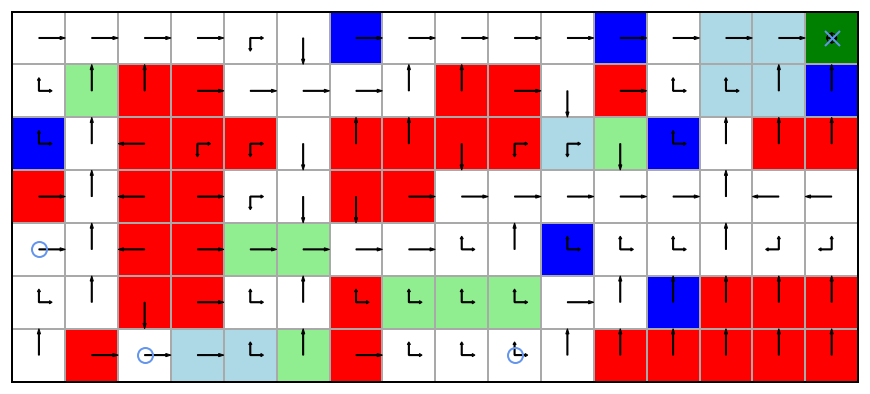

In [3]:
# Expert has a optimal policy
vi_res = ValueIteration().plan_on(gw)
# Use a softmax policy for exploration so the trajectories are not always the same (still chooses the best action with the most probability though). Higher inverse_temperature means more deterministic
softmax_policy = TabularPolicy.from_q_matrix(
    gw.state_list, gw.action_list, q=vi_res._qvaluemat, inverse_temperature=float(1))

gw.plot(featurecolors=featurecolors).plot_policy(softmax_policy)
gw.plot(featurecolors=featurecolors).plot_policy(vi_res.policy)


In [4]:
print(softmax_policy.evaluate_on(gw).initial_value)


-24.125272655857966


In [5]:
print(vi_res.policy.evaluate_on(gw).initial_value)


-8.850520981705522


In [6]:
# Convert our numpy 2d array to a tensor for training
# do I need to convert the labels to a tensor? yes, does it for us in Lambda (target_transform)
class ToTensor(object):
  """Convert ndarrays in sample to Tensors."""

  def __call__(self, sample):
    return torch.from_numpy(sample)


In [7]:
#### Need to create a ML model, train, classify, and evaluate test loss

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


class ActionClassifier(nn.Module):
  def __init__(self):
    super(ActionClassifier, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv1d(1, 16, 3, padding=1),
        nn.BatchNorm1d(16),
        nn.ReLU()
    )
    self.conv2 = nn.Sequential(
        nn.Conv1d(16, 32, 3, padding=1),
        nn.BatchNorm1d(32),
        nn.ReLU()
    )
    self.conv3 = nn.Sequential(
        nn.Conv1d(32, 64, 3, stride=2, padding=1),
        nn.BatchNorm1d(64),
        nn.ReLU()
    )
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 5),
    )
    # don't use softmax bc nn.CrossEntropyLoss takes unnormalized outputs
    # self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    x_conv1 = self.conv1(x)
    x_conv2 = self.conv2(x_conv1)
    x_conv3 = self.conv3(x_conv2)
    x_flat = self.flatten(x_conv3)
    logits = self.linear_relu_stack(x_flat)
    # probabilities = self.softmax(logits)
    return logits


model = ActionClassifier().to(device)
print(model)

Using cuda device
ActionClassifier(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=5, bias=True)
  )
)


In [8]:
# Generate gen_iters of trajectories
gen_iters = 100000
trajectories = []

for _ in range(gen_iters):
  # Starts at one of the labelled starting points
  trajectory = softmax_policy.run_on(gw)
  formatted_traj = {}
  formatted_traj['state_traj'] = trajectory.state_traj
  formatted_traj['action_traj'] = trajectory.action_traj
  trajectories.append(formatted_traj)

features_dataset = FeaturesDataset(gw, trajectories, transform=ToTensor())


In [9]:
# Use Cross Entropy Loss for classification
loss_fn = nn.CrossEntropyLoss()

# better optimizer with a scheduler to decrease learning rate by 0.1 at indicated steps
optimizer = torch.optim.SGD(
    model.parameters(), lr=0.1, weight_decay=0.0001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [2, 4, 7, 9], gamma=0.1)
epochs = 10
batch_size = 128

In [10]:
supervised_learning = ImitationLearning(gw, _, _, model, loss_fn, optimizer, scheduler=scheduler, batch_size=batch_size, epochs=epochs)
optimized_model = supervised_learning.learn(features_dataset)

Using cuda

Epoch 1
-------------------------------
loss: 1.572340  [    0/3772907]

Epoch 2
-------------------------------
loss: 1.076637  [    0/3772907]

Epoch 3
-------------------------------
loss: 1.197359  [    0/3772907]

Epoch 4
-------------------------------
loss: 1.023223  [    0/3772907]

Epoch 5
-------------------------------
loss: 1.145051  [    0/3772907]

Epoch 6
-------------------------------
loss: 1.075265  [    0/3772907]

Epoch 7
-------------------------------
loss: 1.105121  [    0/3772907]

Epoch 8
-------------------------------
loss: 1.204634  [    0/3772907]

Epoch 9
-------------------------------
loss: 1.156366  [    0/3772907]

Epoch 10
-------------------------------
loss: 1.165231  [    0/3772907]

Done!


Learned Policy Initial Value: -31.567333080851466

Softmax Policy Initial Value: -24.125272655857966


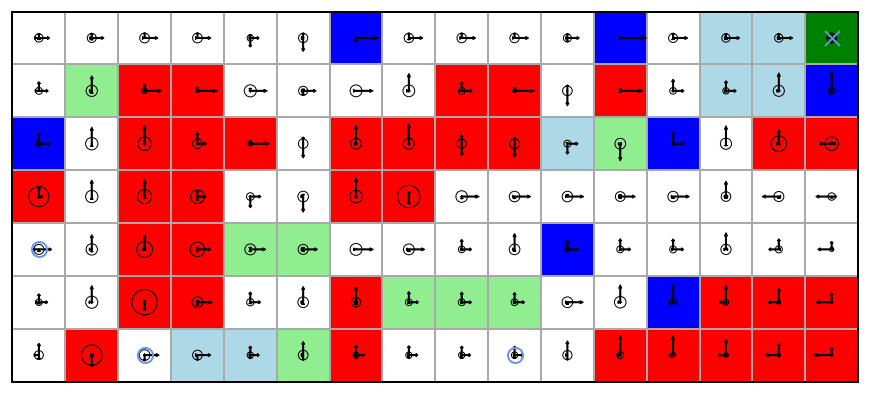

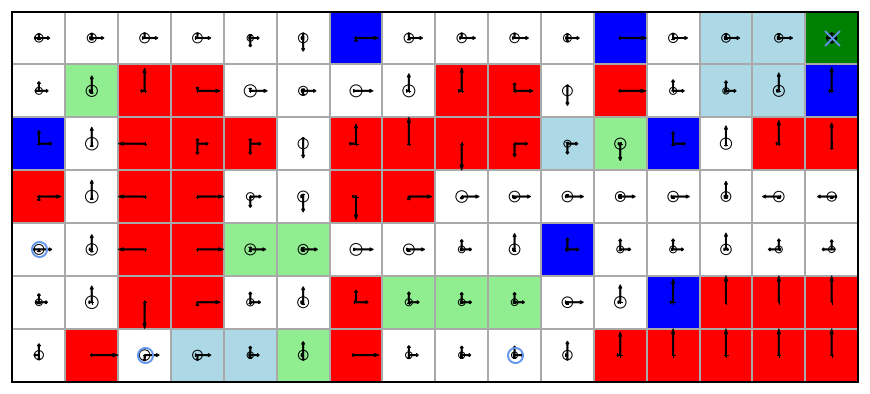

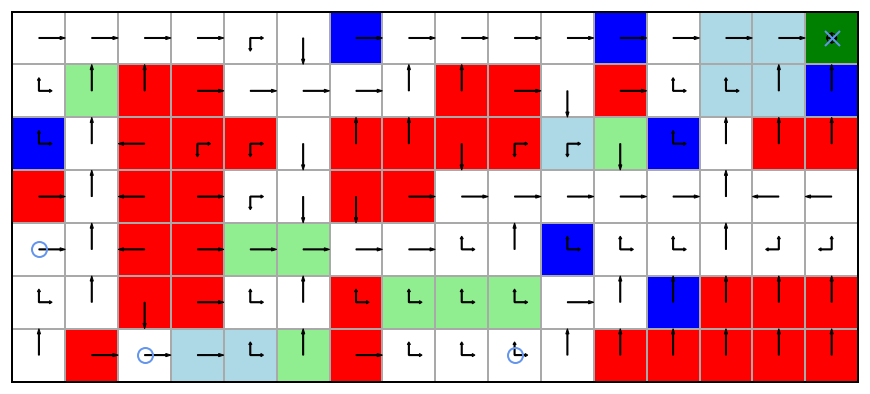

In [11]:
optimized_model.eval()

policy = {}
# int_to_action = {0: "up", 1: "down", 2: "right", 3: "left", 4: "stay"}
int_to_action = {0: frozendict(dx=0, dy=1), 1: frozendict(
    dx=0, dy=-1), 2: frozendict(dx=1, dy=0), 3: frozendict(dx=-1, dy=0), 4: frozendict(dx=0, dy=0)}

softmax_fn = nn.Softmax(dim=1)

# so pred doesn't have a grad_fn attached to it
with torch.no_grad():
  for s in gw.state_list:
    state_feature = torch.from_numpy(np.array([features_dataset.getStateFeature(s)], dtype='f')).to(device)
    # pred = model(state_feature)[0]
    # pred = supervised_learning.model(state_feature)
    pred = optimized_model(state_feature)
    probs = softmax_fn(pred)[0]
    policy[s] = {}
    # for each action in each state, grab from the "pred" result the probability of taking this action in this state and add that to the dictionary policy which is a dictionary with states as keys and a dictionary of "action: prob of taking this action in this state" as values
    for a_i, prob in enumerate(probs):
      policy[s][int_to_action[a_i]] = prob.item()

# to turn policy into an actual policy object that we can call the MSDM functions on
policy = TabularPolicy({s: DictDistribution(ap) for s, ap in policy.items()})
gw.plot(featurecolors=featurecolors).plot_policy(policy)
gw.plot(featurecolors=featurecolors).plot_policy(softmax_policy)
gw.plot(featurecolors=featurecolors).plot_policy(vi_res.policy)
print(f"Learned Policy Initial Value: {policy.evaluate_on(gw).initial_value}")
print()
print(f"Softmax Policy Initial Value: {softmax_policy.evaluate_on(gw).initial_value}")


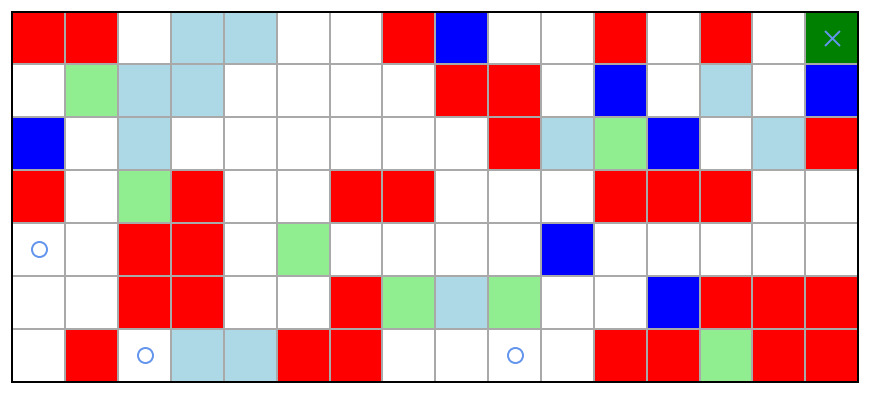

In [12]:
# Create a gridworld
gw1 = GridWorld(
    tile_array=[
        "xx.bb..xc..x.x.g",
        ".abb....xx.c.b.c",
        "c.b......xbac.bx",
        "x.ax..xx...xxx..",
        "s.xx.a....c.....",
        "..xx..xaba..cxxx",
        ".xsbbxx..s.xxaxx",
    ],
    feature_rewards={
        'g': 10,
        'x': -500,
        'c': -5,
        '.': 0,
        'a': 0,
        'b': 0,
    },
    absorbing_features=('g'),
    initial_features=('s'),
    discount_rate=0.99,
)
featurecolors = {
    'g': 'green',
    'x': 'red',
    'c': 'blue',
    '.': 'white',
    'a': 'lightgreen',
    'b': 'lightblue'
}
gw1.plot(featurecolors=featurecolors)


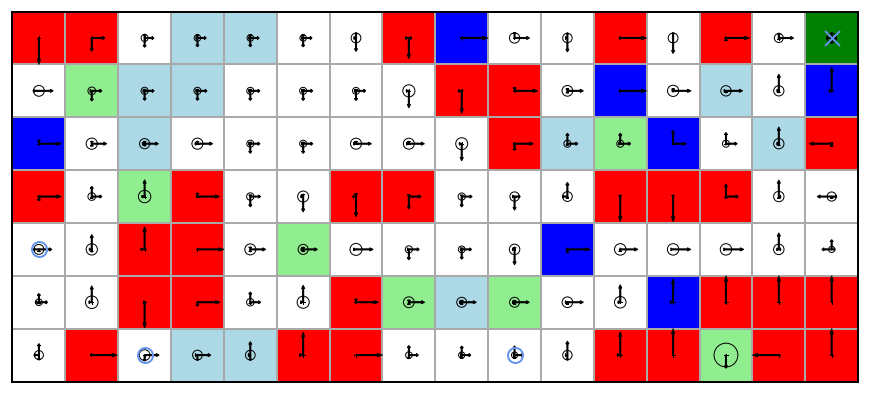

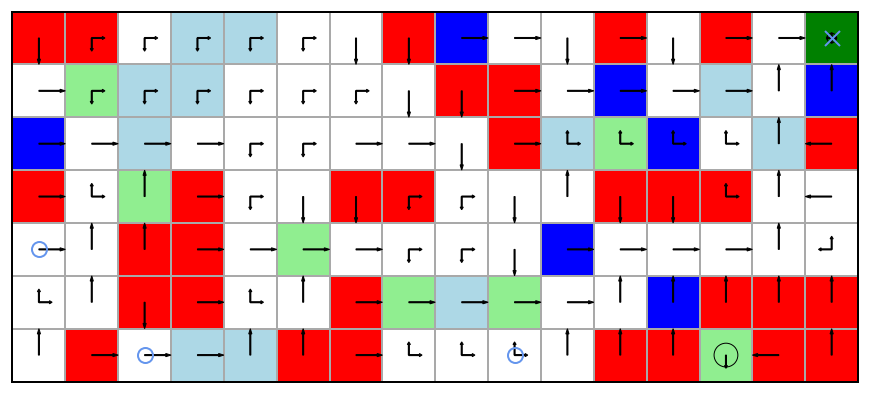

In [13]:
# Expert has a optimal policy
vi_res = ValueIteration().plan_on(gw1)
# Use a softmax policy for exploration so the trajectories are not always the same (still chooses the best action with the most probability though). Higher inverse_temperature means more deterministic
softmax_policy = TabularPolicy.from_q_matrix(
    gw1.state_list, gw1.action_list, q=vi_res._qvaluemat, inverse_temperature=float(1))

gw1.plot(featurecolors=featurecolors).plot_policy(softmax_policy)
gw1.plot(featurecolors=featurecolors).plot_policy(vi_res.policy)


In [15]:
features_dataset2 = FeaturesDataset(gw1, trajectories, transform=ToTensor())

Learned Policy Initial Value: -2366.3438819604467

Softmax Policy Initial Value: -24.660047251121526


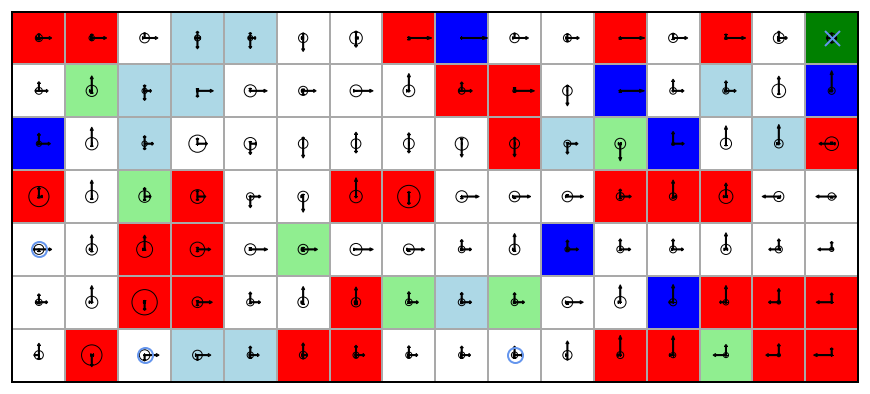

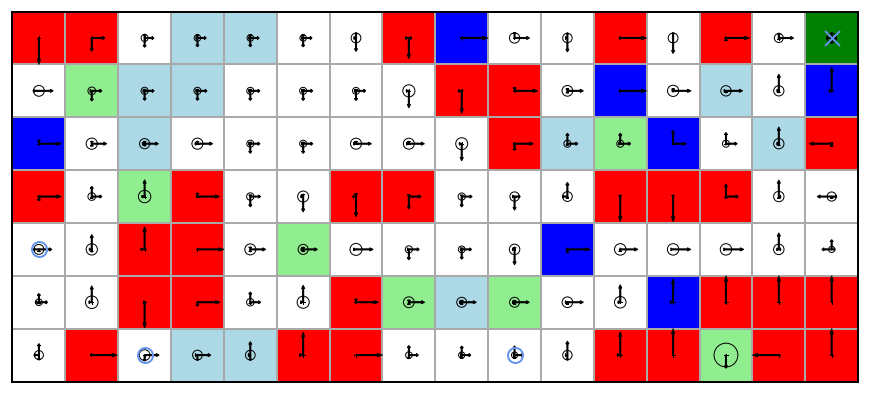

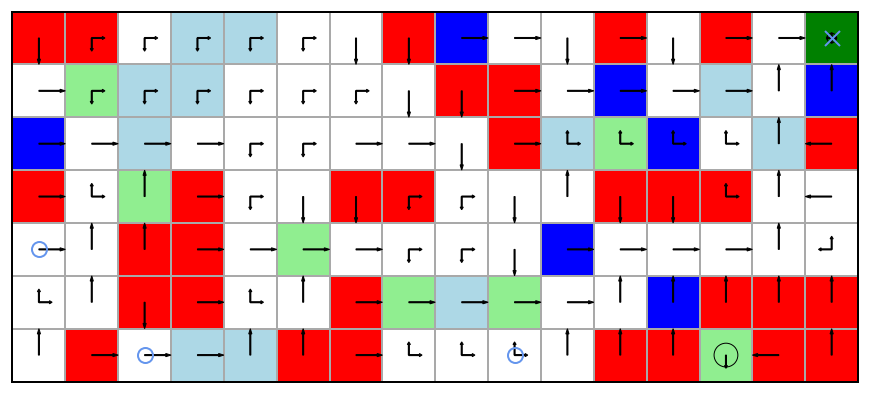

In [16]:
optimized_model.eval()

# so pred doesn't have a grad_fn attached to it
with torch.no_grad():
  for s in gw1.state_list:
    state_feature = torch.from_numpy(np.array([features_dataset2.getStateFeature(s)], dtype='f')).to(device)
    # pred = model(state_feature)[0]
    pred = optimized_model(state_feature)
    probs = softmax_fn(pred)[0]
    policy[s] = {}
    # for each action in each state, grab from the "pred" result the probability of taking this action in this state and add that to the dictionary policy which is a dictionary with states as keys and a dictionary of "action: prob of taking this action in this state" as values
    for a_i, prob in enumerate(probs):
      policy[s][int_to_action[a_i]] = prob.item()

# to turn policy into an actual policy object that we can call the MSDM functions on
policy = TabularPolicy({s: DictDistribution(ap) for s, ap in policy.items()})
gw1.plot(featurecolors=featurecolors).plot_policy(policy)
gw1.plot(featurecolors=featurecolors).plot_policy(softmax_policy)
gw1.plot(featurecolors=featurecolors).plot_policy(vi_res.policy)

print(f"Learned Policy Initial Value: {policy.evaluate_on(gw1).initial_value}")
print()
print(f"Softmax Policy Initial Value: {softmax_policy.evaluate_on(gw1).initial_value}")
